In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier


from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import joblib

warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(r"D:\Project7\application_train.csv", nrows= num_rows)
    test_df = pd.read_csv(r"D:\Project7\application_test.csv", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(r"D:\Project7\bureau.csv", nrows = num_rows)
    bb = pd.read_csv(r"D:\Project7\bureau_balance.csv", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(r"D:\Project7\previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(r"D:\Project7\POS_CASH_balance.csv", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r"D:\Project7\installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(r"D:\Project7\credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [2]:
num_rows = 10000
df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau


prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev


pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos


ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins


cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc


train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

del df

f_score = dict()
lim = dict()
feats = [f for f in train_df.columns if f not in [
    'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
np.savetxt("feats.csv", np.atleast_2d(feats), fmt="%s", delimiter=",")


test_df.to_pickle("test_df.gz", compression={
                  'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Previous applications df shape: (9734, 242)
Pos-cash balance df shape: (9494, 15)
Installments payments df shape: (8893, 26)
Credit card balance df shape: (9520, 131)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


###  Defintion des agorythmes
#### Lightgbm

In [3]:
def lightgbm(num_folds, beta = 1, grid_search = True):
    
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    if grid_search :
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LGBMClassifier()
        steps = [("over", over), ("under", under), ("model", clf)]
        LGBM_pipe = Pipeline(steps=steps)

        params = [{"model__n_estimators" : [100, 1000, 10000],
                  "model__learning_rate" : [0.001, 0.01, 0.1], 
                  "model__num_leaves" : [20, 30, 40]}]

        gs_LGBM = GridSearchCV(LGBM_pipe,
                              param_grid = params,
                               scoring = "roc_auc",
                               cv=5)

        gs_LGBM.fit(train_df[feats], train_df['TARGET'])
        params = best_params(gs_LGBM)
        print(params)
    else :
        params = {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 20}
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.3)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LGBMClassifier(**params)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y, model__eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            model__eval_metric= "auc", model__verbose= 200, model__early_stopping_rounds= 200)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        


        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        

        
        del clf, train_x, train_y, valid_x, valid_y, pipeline
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET LGBM"], lim["LGBM"] = classifier(sub_preds, fb_lgbm, thresh)
    test_df["TARGET LGBM score"] = sub_preds
    
  
    return feature_importance_df, np.max(fb_lgbm), oof_preds, params


### Random forest

In [4]:
def RF_classifier(num_folds, beta = 1, grid_search = True):
    
    print("Starting Random Forest. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    if grid_search :
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = RandomForestClassifier()
        steps = [("over", over), ("under", under), ("model", clf)]
        RF_pipe = Pipeline(steps=steps)

        params = [{"model__n_estimators" : [10, 100, 1000],
                  "model__max_features" : ["sqrt", "log2"], 
                  "model__n_jobs" : [6]}]

        gs_RF = GridSearchCV(RF_pipe,
                              param_grid = params,
                               scoring = "roc_auc",
                               cv=5)

        gs_RF.fit(train_df[feats], train_df['TARGET'])
        params = best_params(gs_RF)
        print(params)
    else :
        params = {'max_features': 'sqrt', 'n_estimators': 1000, 'n_jobs': 6}
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = RandomForestClassifier(**params)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats])[:, 1] / folds.n_splits
        


        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        

        
        del clf, pipeline, train_x, train_y, valid_x, valid_y
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET RF"], lim["RF"] = classifier(sub_preds, fb_lgbm, thresh)
   
    return feature_importance_df, np.max(fb_lgbm)


### KNN

In [5]:
def KNN(num_folds, beta = 1, grid_search = False):
    
    print("Starting KNN. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    if grid_search :
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = KNeighborsClassifier()
        steps = [("over", over), ("under", under), ("model", clf)]
        RF_pipe = Pipeline(steps=steps)

        params = [{"model__n_neighbors" : [4, 5, 6, 7, 8, 9],
                  "model__algorithm" : ["ball_tree", "kd_tree"], 
                  "model__n_jobs" : [6]}]

        gs_RF = GridSearchCV(RF_pipe,
                              param_grid = params,
                               scoring = "roc_auc",
                               cv=5)

        gs_RF.fit(train_df[feats], train_df['TARGET'])
        params = best_params(gs_RF)
        print(params)
    else :
        params = {'algorithm': 'kd_tree', 'n_jobs': 6, 'n_neighbors': 9}
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.1)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = KNeighborsClassifier(**params)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats])[:, 1] / folds.n_splits      

        
        del clf, train_x, train_y, valid_x, valid_y, pipeline
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET KNN"], lim["KNN"] = classifier(sub_preds, fb_lgbm, thresh)
   
    return np.max(fb_lgbm)


### Régression linéaire

In [6]:
def Linear(num_folds, beta = 1):
    
    print("Starting Logistic Regression. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LogisticRegression(n_jobs = 6, max_iter = 5000)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats])[:, 1] / folds.n_splits      

        
        del clf, train_x, train_y, valid_x, valid_y, pipeline
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET Linear"], lim["Linear"] = classifier(sub_preds, fb_lgbm, thresh)
   
    return np.max(fb_lgbm)


### Fonction de scoring

In [7]:
#Permet de produire la courbe du fbeta score
def fbscore (X, y, beta = 1):
    
    pre, rec, thresh = precision_recall_curve(X, y)
    pre = pre[:-1]
    rec = rec[:-1]
    
    b2 = beta**2
    temp = pd.DataFrame(pre, columns=["pre"])
    temp["rec"] = rec
    temp["fb"] = ((1 + b2)*(temp["pre"] * temp["rec"]))/(b2 * temp["pre"] + temp["rec"])
    temp["fb"].fillna(0, inplace=True)
    fb = temp["fb"].to_numpy()
    
    return fb, thresh

# D'après la courbe du fbeta score, classe les éléments dans une ou l'autre catégorie selon la 
# probabilité correspondant au fbeta score maximal
def classifier (target, fbtab, thresh):
    lim = thresh[np.argmax(fbtab)]
    tab_class = (target > lim).astype(int)
    return tab_class, lim

### Tests des différentes fonctions

In [8]:
feature_imp_lgbm, f_score["LGBM"], pred_train, params_lgbm = lightgbm(
    num_folds = 6, beta = 0.1, grid_search=False)

Starting LightGBM. Train shape: (10000, 768), test shape: (10000, 768)


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.825937	valid_0's binary_logloss: 0.286448	valid_1's auc: 0.757427	valid_1's binary_logloss: 0.303823
[400]	valid_0's auc: 0.890782	valid_0's binary_logloss: 0.230494	valid_1's auc: 0.761986	valid_1's binary_logloss: 0.271545


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.818357	valid_0's binary_logloss: 0.285567	valid_1's auc: 0.725363	valid_1's binary_logloss: 0.312009
[400]	valid_0's auc: 0.88211	valid_0's binary_logloss: 0.231785	valid_1's auc: 0.739672	valid_1's binary_logloss: 0.2792
[600]	valid_0's auc: 0.929417	valid_0's binary_logloss: 0.200578	valid_1's auc: 0.74768	valid_1's binary_logloss: 0.268549
[800]	valid_0's auc: 0.956235	valid_0's binary_logloss: 0.179263	valid_1's auc: 0.748718	valid_1's binary_logloss: 0.265801


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.818768	valid_0's binary_logloss: 0.288876	valid_1's auc: 0.774395	valid_1's binary_logloss: 0.299568
[400]	valid_0's auc: 0.881126	valid_0's binary_logloss: 0.234595	valid_1's auc: 0.787667	valid_1's binary_logloss: 0.262895
[600]	valid_0's auc: 0.926939	valid_0's binary_logloss: 0.203278	valid_1's auc: 0.786793	valid_1's binary_logloss: 0.252537


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.820874	valid_0's binary_logloss: 0.289953	valid_1's auc: 0.746304	valid_1's binary_logloss: 0.302007
[400]	valid_0's auc: 0.882184	valid_0's binary_logloss: 0.235089	valid_1's auc: 0.761468	valid_1's binary_logloss: 0.264347
[600]	valid_0's auc: 0.927627	valid_0's binary_logloss: 0.204628	valid_1's auc: 0.766765	valid_1's binary_logloss: 0.253731
[800]	valid_0's auc: 0.955387	valid_0's binary_logloss: 0.183061	valid_1's auc: 0.770672	valid_1's binary_logloss: 0.249139
[1000]	valid_0's auc: 0.971244	valid_0's binary_logloss: 0.166035	valid_1's auc: 0.773733	valid_1's binary_logloss: 0.245862


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.829989	valid_0's binary_logloss: 0.283853	valid_1's auc: 0.709472	valid_1's binary_logloss: 0.314187


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.820001	valid_0's binary_logloss: 0.29418	valid_1's auc: 0.689607	valid_1's binary_logloss: 0.302411
[400]	valid_0's auc: 0.882867	valid_0's binary_logloss: 0.238448	valid_1's auc: 0.716885	valid_1's binary_logloss: 0.263744
[600]	valid_0's auc: 0.924744	valid_0's binary_logloss: 0.207786	valid_1's auc: 0.721497	valid_1's binary_logloss: 0.25436
[800]	valid_0's auc: 0.950436	valid_0's binary_logloss: 0.187045	valid_1's auc: 0.722815	valid_1's binary_logloss: 0.251573
[1000]	valid_0's auc: 0.966494	valid_0's binary_logloss: 0.170085	valid_1's auc: 0.720466	valid_1's binary_logloss: 0.249817
F-0.1 score max : 0.33906116642958745


In [9]:
test_df["TARGET LGBM"].value_counts()

0    9848
1     152
Name: TARGET LGBM, dtype: int64

In [10]:
feature_imp_rf, f_score["RF"] = RF_classifier(num_folds = 6, beta = 0.1, grid_search=False)

Starting Random Forest. Train shape: (10000, 768), test shape: (10000, 770)
F-0.1 score max : 0.40225108225108225


In [11]:
test_df["TARGET RF"].value_counts()

0    9973
1      27
Name: TARGET RF, dtype: int64

In [12]:
f_score["KNN"] = KNN(num_folds = 6, beta = 0.1, grid_search=False)

Starting KNN. Train shape: (10000, 768), test shape: (10000, 771)
F-0.1 score max : 0.10689380210221096


In [13]:
test_df["TARGET KNN"].value_counts()

0    9877
1     123
Name: TARGET KNN, dtype: int64

In [14]:
f_score["Linear"] = Linear(num_folds = 6, beta = 0.1)

Starting Logistic Regression. Train shape: (10000, 768), test shape: (10000, 772)
F-0.1 score max : 0.16391408114558473


In [15]:
test_df["TARGET Linear"].value_counts()

0    9976
1      24
Name: TARGET Linear, dtype: int64

Text(0.5, 1.0, ' Comparaison fbeta score ')

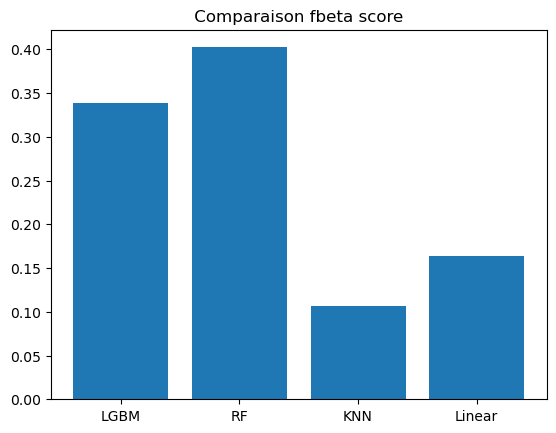

In [17]:
plt.bar(f_score.keys(), f_score.values())
plt.title(" Comparaison fbeta score ")

###  Oversampling Smote

In [20]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy = 0.5)
clf = LGBMClassifier(**params_lgbm)

steps = [("over", over), ("under", under), ("model", clf)]
pipeline = Pipeline(steps=steps)

pipeline.fit(train_df[feats], train_df["TARGET"])


Pipeline(steps=[('over', SMOTE(sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 LGBMClassifier(learning_rate=0.01, n_estimators=1000,
                                num_leaves=20))])

### Graphique de feature importance locale avec LGBM

In [27]:
feat_imp = pd.DataFrame()

In [28]:
feat_imp ["importances"] = clf.feature_importances_

In [29]:
feat_imp ["features"] = feats

In [30]:
feat_imp .sort_values(by=["importances"], ascending=False, inplace=True)

Text(0.5, 1.0, 'local feature importances')

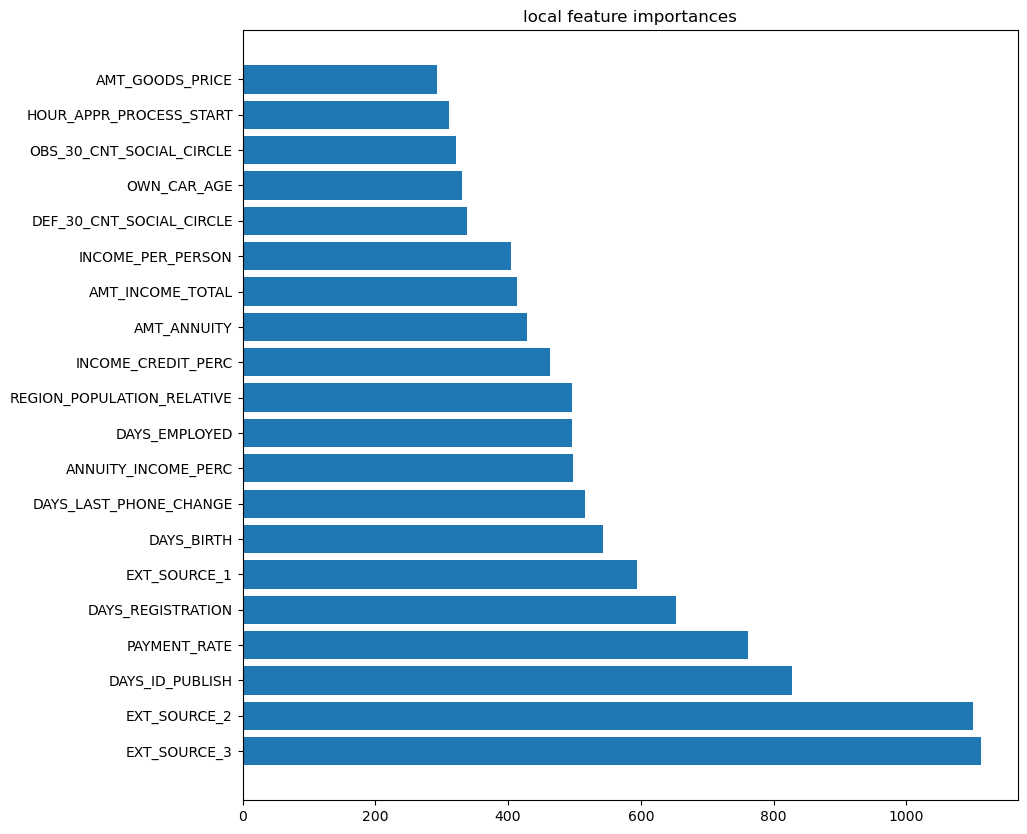

In [31]:
fig = plt.figure(figsize=(10,10))
plt.barh(feat_imp ["features"][:20], feat_imp ["importances"][:20])
plt.title("local feature importances")

### Graphique de feature importance globale (shap)

In [32]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf)
joblib.dump(explainer, "shap_explainer.joblib")

['shap_explainer.joblib']

In [33]:
shap_values = explainer.shap_values(test_df[feats])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


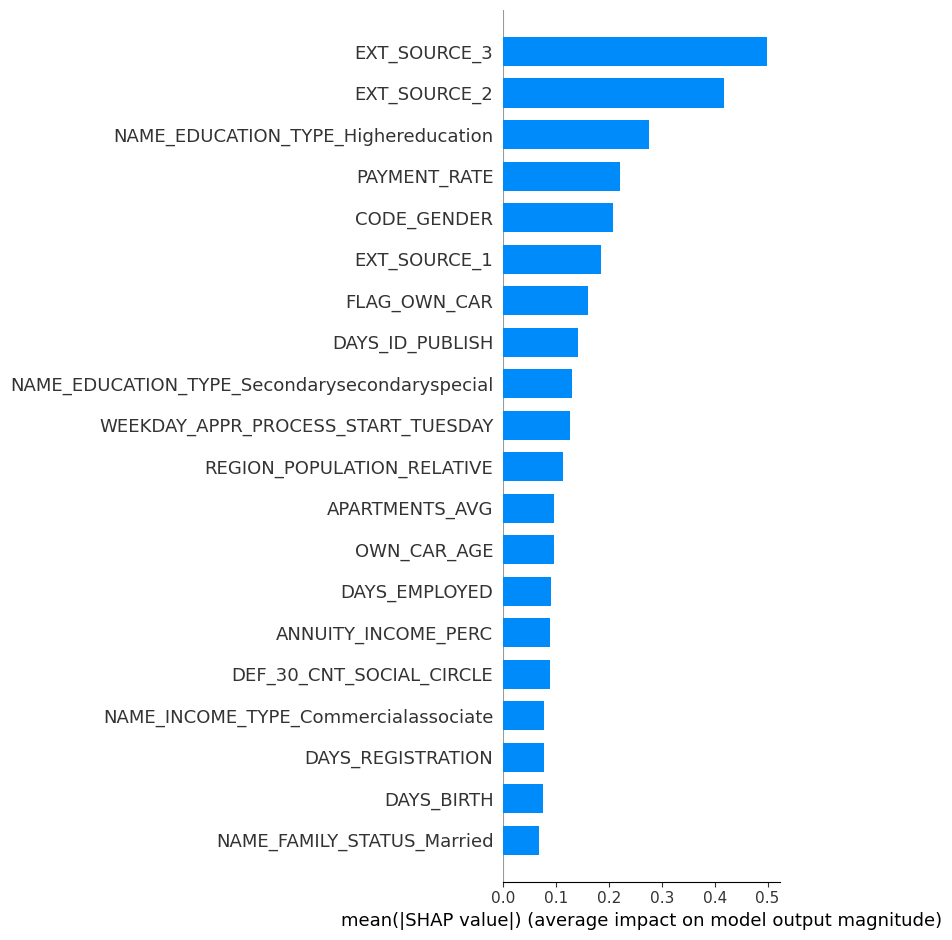

In [34]:
shap.summary_plot(shap_values[1], test_df[feats], plot_type='bar')